# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict


# Settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
tqdm.pandas(desc="Applying mooder_pipeline")

/Users/danielebelmiro/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# CSVs Loading

In [2]:
reviews = pd.read_csv('/Users/danielebelmiro/Data Analytics Bootcamp/Rotten/clean_reviews.csv')
reviews.head()

,id,title,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,cleanedReviewText
0,beavers,Beavers,1145982,2003-05-23,Ivan M. Lincoln,False,fresh,Deseret News (Salt Lake City),"Timed to be just long enough for most youngsters' brief attention spans -- and it's packed with plenty of interesting activity, both on land and under the water.",POSITIVE,Timed to be just long enough for most youngsters brief attention spans and its packed with plenty of interesting activity both on land and under the water
1,blood_mask,Blood Mask,1636744,2007-06-02,The Foywonder,False,rotten,Dread Central,"It doesn't matter if a movie costs 300 million or only 300 dollars; good is good and bad is bad, and Bloodmask: The Possession of Nicole Lameroux is just plain bad.",NEGATIVE,It doesnt matter if a movie costs 300 million or only 300 dollars good is good and bad is bad and Bloodmask The Possession of Nicole Lameroux is just plain bad
2,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2590987,2019-05-28,Reuben Baron,False,fresh,CBR,"The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped, but no live-action reference footage was used. The quality is due to the skill of the animators and Kodama's love for professional wrestling.",POSITIVE,The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped but no liveaction reference footage was used The quality is due to the skill of the animators and Kodamas love for professional wrestling
3,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2558908,2019-02-14,Matt Schley,False,rotten,Japan Times,The film's out-of-touch attempts at humor may find them hunting for the reason the franchise was so popular in the first place.,NEGATIVE,The films outoftouch attempts at humor may find them hunting for the reason the franchise was so popular in the first place
4,dangerous_men_2015,Dangerous Men,2504681,2018-08-29,Pat Padua,False,fresh,DCist,Its clumsy determination is endearing and sometimes wildly entertaining,POSITIVE,Its clumsy determination is endearing and sometimes wildly entertaining


In [3]:
movies = pd.read_csv('/Users/danielebelmiro/Data Analytics Bootcamp/Rotten/clean_movies.csv')
movies.head()

,id,title,audienceScore,tomatoMeter,runtimeMinutes,genre,originalLanguage,director,writer,release_year
0,love_lies,"Love, Lies",43.0,65.76,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",Unknown
1,dinosaur_island_2002,Dinosaur Island,70.0,65.76,80.5,Fantasy,English,Will Meugniot,John Loy,2017
2,dinosaur_island_2002,Dinosaur Island,70.0,65.76,80.5,Adventure,English,Will Meugniot,John Loy,2017
3,dinosaur_island_2002,Dinosaur Island,70.0,65.76,80.5,Animation,English,Will Meugniot,John Loy,2017
4,adrift_2018,Adrift,65.0,69.00,93.0,Adventure,English,Baltasar Kormákur,"Aaron Kandell,Jordan Kandell,David Branson Smith",2018


In [4]:
movies.loc[movies['title'] == "Five"]

,id,title,audienceScore,tomatoMeter,runtimeMinutes,genre,originalLanguage,director,writer,release_year
6754,five,Five,52.00,73.00,76.166667,Sci-fi,English,Arch Oboler,Unknown,2009
16666,five_2020,Five,55.67,65.76,76.166667,Drama,English,Jeffrey DeChausse,Jeffrey DeChausse,Unknown
53983,five_2011,Five,75.00,65.76,76.166667,Comedy,English,"Jennifer Aniston,Alicia Keys,Demi Moore,Patty Jenkins,Penelope Spheeris",Unknown,2012
53984,five_2011,Five,75.00,65.76,76.166667,Drama,English,"Jennifer Aniston,Alicia Keys,Demi Moore,Patty Jenkins,Penelope Spheeris",Unknown,2012
66026,771459240,Five,55.67,65.76,76.166667,Documentary,Unknown,Abbas Kiarostami,Abbas Kiarostami,Unknown
84031,five_2016,Five,63.00,65.76,76.166667,Drama,French,Igor Gotesman,Igor Gotesman,Unknown


# Model Loading

In [4]:
# Load the pre-trained model and tokenizer from Hugging Face's transformers library
MODEL = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Emotion Classification Pipeline

In [5]:
# Create the emotion classification pipeline
emotion_classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)

/Users/danielebelmiro/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
def mooder_pipeline(text):
    # Ensure text is of type string
    text = str(text)
    # Get predictions from the pipeline
    predictions = emotion_classifier(text)[0]
    # Exclude the 'neutral' emotion
    predictions_without_neutral = [p for p in predictions if p['label'] != 'neutral']
    # Calculate the total score excluding 'neutral'
    total_score = sum(p['score'] for p in predictions_without_neutral)
    # Normalize the scores to percentages
    for p in predictions_without_neutral:
        p['percentage'] = (p['score'] / total_score) * 100
    # Sort by score in descending order
    sorted_predictions = sorted(predictions_without_neutral, key=lambda x: x['score'], reverse=True)
    # Get the top 3 emotions
    top_moods = [(p['label'], p['percentage']) for p in sorted_predictions[:3]]
    return top_moods

# Predicting Emotions in a Sample Dataset

In [7]:
# Select a random sample of 100 reviews
sample_reviews = reviews.sample(n=100, random_state=42)

# Apply the `mooder_pipeline` function to the sample reviews
sample_reviews['predicted_moods'] = sample_reviews['cleanedReviewText'].apply(mooder_pipeline)

# Display the first rows with predicted emotions
sample_reviews[['cleanedReviewText', 'predicted_moods']].head()

,cleanedReviewText,predicted_moods
439863,A great creative and hilarious idea we leave the film singing despite the pain Full Review in Spanish,"[(admiration, 53.37818029837017), (amusement, 33.14455231691479), (joy, 3.93635260183538)]"
1310710,The effect of The Fog of War is to impress upon us the frailty and uncertainty of our leaders,"[(confusion, 29.791889215938173), (realization, 19.711487300762393), (approval, 14.817934861524861)]"
1099553,It seems as though the entire budget of this movie was spent on expensive set decoration,"[(realization, 52.213622962868044), (disappointment, 13.48196595717604), (approval, 8.510683863254046)]"
63988,It took years before Disney would match the quality of this first film from expatriate Don Bluth,"[(realization, 34.28167992177586), (disappointment, 18.923050847729815), (disapproval, 11.637204569731132)]"
493706,Maggie Gyllenhaal and Parker Sevaks interactions come across seamlessly here Its fascinating to watch them together regardless of how questionable the situations become,"[(admiration, 62.38716196327171), (approval, 27.80556787844608), (excitement, 2.482049212521594)]"


#### Visualizing the frequency of predicted emotions:

approval          66
admiration        41
realization       38
annoyance         28
disapproval       27
disappointment    26
amusement         15
joy               13
optimism           7
excitement         7
confusion          7
fear               5
love               4
sadness            4
caring             3
disgust            3
gratitude          3
relief             1
surprise           1
nervousness        1
Name: count, dtype: int64


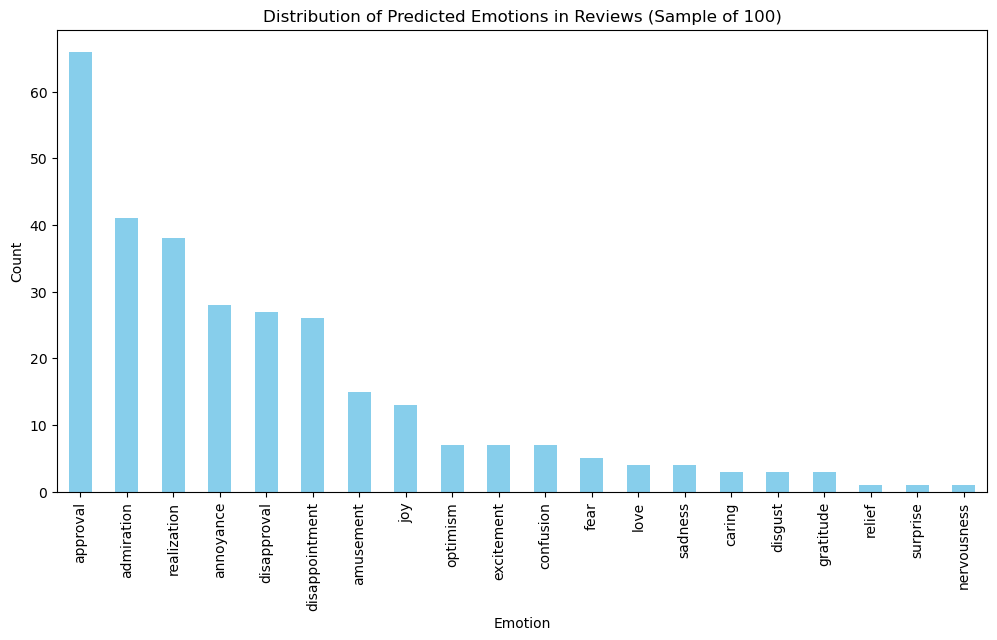

In [8]:
# Create a list of all predicted emotions
all_predicted_moods_sample = [mood for moods in sample_reviews['predicted_moods'] for mood, _ in moods]

# Count the predicted emotions
emotion_counts_sample = pd.Series(all_predicted_moods_sample).value_counts()
print(emotion_counts_sample)

# Plot the counts of predicted emotions
plt.figure(figsize=(12, 6))
emotion_counts_sample.plot(kind='bar', color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Predicted Emotions in Reviews (Sample of 100)')
plt.show()

# Predicting Emotions in the Reviews Dataset

In [9]:
# Apply the `mooder_pipeline` function to the reviews with a progress bar
reviews['predicted_moods'] = reviews['cleanedReviewText'].progress_apply(mooder_pipeline)

# Display the updated DataFrame
reviews.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Applying mooder_pipeline: 100%|████| 1363579/1363579 [44:34:54<00:00,  8.50it/s]


,id,title,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,cleanedReviewText,predicted_moods
0,beavers,Beavers,1145982,2003-05-23,Ivan M. Lincoln,False,fresh,Deseret News (Salt Lake City),"Timed to be just long enough for most youngsters' brief attention spans -- and it's packed with plenty of interesting activity, both on land and under the water.",POSITIVE,Timed to be just long enough for most youngsters brief attention spans and its packed with plenty of interesting activity both on land and under the water,"[(excitement, 35.543839830098335), (approval, 33.46019927394191), (admiration, 14.496543413653109)]"
1,blood_mask,Blood Mask,1636744,2007-06-02,The Foywonder,False,rotten,Dread Central,"It doesn't matter if a movie costs 300 million or only 300 dollars; good is good and bad is bad, and Bloodmask: The Possession of Nicole Lameroux is just plain bad.",NEGATIVE,It doesnt matter if a movie costs 300 million or only 300 dollars good is good and bad is bad and Bloodmask The Possession of Nicole Lameroux is just plain bad,"[(disapproval, 56.05641547237329), (annoyance, 16.554232640392087), (disappointment, 6.739219413595081)]"
2,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2590987,2019-05-28,Reuben Baron,False,fresh,CBR,"The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped, but no live-action reference footage was used. The quality is due to the skill of the animators and Kodama's love for professional wrestling.",POSITIVE,The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped but no liveaction reference footage was used The quality is due to the skill of the animators and Kodamas love for professional wrestling,"[(admiration, 80.08288365216127), (approval, 11.413153330660675), (realization, 2.203470607201049)]"
3,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2558908,2019-02-14,Matt Schley,False,rotten,Japan Times,The film's out-of-touch attempts at humor may find them hunting for the reason the franchise was so popular in the first place.,NEGATIVE,The films outoftouch attempts at humor may find them hunting for the reason the franchise was so popular in the first place,"[(amusement, 22.690977576957067), (realization, 22.334023735757526), (approval, 20.482867563064357)]"
4,dangerous_men_2015,Dangerous Men,2504681,2018-08-29,Pat Padua,False,fresh,DCist,Its clumsy determination is endearing and sometimes wildly entertaining,POSITIVE,Its clumsy determination is endearing and sometimes wildly entertaining,"[(amusement, 49.197768434566136), (admiration, 31.226476779217876), (joy, 13.045682308905867)]"


In [12]:
# Save the DataFrame to a CSV file
# reviews.to_csv('/Users/danielebelmiro/Data Analytics Bootcamp/Rotten/reviews_emotions.csv', index=False)

In [13]:
# Load the DataFrame from a CSV file
# reviews = pd.read_csv('/Users/danielebelmiro/Data Analytics Bootcamp/Rotten/reviews_emotions.csv')

,id,title,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,cleanedReviewText,predicted_moods
0,beavers,Beavers,1145982,2003-05-23,Ivan M. Lincoln,False,fresh,Deseret News (Salt Lake City),"Timed to be just long enough for most youngsters' brief attention spans -- and it's packed with plenty of interesting activity, both on land and under the water.",POSITIVE,Timed to be just long enough for most youngsters brief attention spans and its packed with plenty of interesting activity both on land and under the water,"[('excitement', 35.543839830098335), ('approval', 33.46019927394191), ('admiration', 14.496543413653109)]"
1,blood_mask,Blood Mask,1636744,2007-06-02,The Foywonder,False,rotten,Dread Central,"It doesn't matter if a movie costs 300 million or only 300 dollars; good is good and bad is bad, and Bloodmask: The Possession of Nicole Lameroux is just plain bad.",NEGATIVE,It doesnt matter if a movie costs 300 million or only 300 dollars good is good and bad is bad and Bloodmask The Possession of Nicole Lameroux is just plain bad,"[('disapproval', 56.05641547237329), ('annoyance', 16.554232640392087), ('disappointment', 6.739219413595081)]"
2,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2590987,2019-05-28,Reuben Baron,False,fresh,CBR,"The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped, but no live-action reference footage was used. The quality is due to the skill of the animators and Kodama's love for professional wrestling.",POSITIVE,The choreography is so precise and lifelike at points one might wonder whether the movie was rotoscoped but no liveaction reference footage was used The quality is due to the skill of the animators and Kodamas love for professional wrestling,"[('admiration', 80.08288365216127), ('approval', 11.413153330660675), ('realization', 2.203470607201049)]"
3,city_hunter_shinjuku_private_eyes,City Hunter: Shinjuku Private Eyes,2558908,2019-02-14,Matt Schley,False,rotten,Japan Times,The film's out-of-touch attempts at humor may find them hunting for the reason the franchise was so popular in the first place.,NEGATIVE,The films outoftouch attempts at humor may find them hunting for the reason the franchise was so popular in the first place,"[('amusement', 22.690977576957067), ('realization', 22.334023735757526), ('approval', 20.482867563064357)]"
4,dangerous_men_2015,Dangerous Men,2504681,2018-08-29,Pat Padua,False,fresh,DCist,Its clumsy determination is endearing and sometimes wildly entertaining,POSITIVE,Its clumsy determination is endearing and sometimes wildly entertaining,"[('amusement', 49.197768434566136), ('admiration', 31.226476779217876), ('joy', 13.045682308905867)]"


#### Filtering df by movie id:

In [23]:
reviews.loc[reviews['id'] == 'inside_out_2015']

,id,title,reviewId,creationDate,criticName,isTopCritic,reviewState,publicatioName,reviewText,scoreSentiment,cleanedReviewText,predicted_moods
360278,inside_out_2015,Inside Out,102712284,2022-07-25,Rahul Desai,False,fresh,News9 Live (India),I was convinced that Riley's journey was mine.,POSITIVE,I was convinced that Rileys journey was mine,"[('realization', 31.385255601438555), ('approval', 29.624650677380025), ('confusion', 19.896058710814007)]"
360279,inside_out_2015,Inside Out,102705346,2022-06-30,Cody Dericks,False,fresh,Next Best Picture,An achievement of world-building and screenwriting in ways that are rarely seen in any movie&#44; let alone an animated film ostensibly aimed at children&#46;,POSITIVE,An achievement of worldbuilding and screenwriting in ways that are rarely seen in any movie let alone an animated film ostensibly aimed at children,"[('admiration', 59.02846762302718), ('approval', 15.164671010570757), ('realization', 6.769611797972791)]"
360280,inside_out_2015,Inside Out,102698096,2022-06-09,Brian Eggert,False,fresh,Deep Focus Review,Inside Out beautifully transforms emotional conflict into an adventure&#44; a surreal look at the internal machinations that encompass why we feel the way we do&#46;,POSITIVE,Inside Out beautifully transforms emotional conflict into an adventure a surreal look at the internal machinations that encompass why we feel the way we do,"[('admiration', 75.82516364114886), ('approval', 14.806422546844994), ('excitement', 1.9706218609570219)]"
360281,inside_out_2015,Inside Out,2828794,2021-10-04,Nikki Baughan,False,fresh,AWFJ.org,"Combining a classic fish out of water tale with the studio's trademark sharp, funny, insightful writing, delivered by an exceptional comic cast, and, of course, those gorgeous visuals.",POSITIVE,Combining a classic fish out of water tale with the studios trademark sharp funny insightful writing delivered by an exceptional comic cast and of course those gorgeous visuals,"[('admiration', 85.46721258771885), ('approval', 8.022798360072612), ('realization', 0.8916387061711378)]"
360282,inside_out_2015,Inside Out,2828792,2021-10-04,Nell Minow,True,fresh,AWFJ.org,"Inside Out is one of the best movies of the year, psychologically astute, witty, imaginative, utterly captivating.",POSITIVE,Inside Out is one of the best movies of the year psychologically astute witty imaginative utterly captivating,"[('admiration', 90.17956990514749), ('approval', 4.23970233618686), ('disapproval', 0.5480116301948795)]"
...,...,...,...,...,...,...,...,...,...,...,...,...
360655,inside_out_2015,Inside Out,2262786,2015-05-18,Sophie Monks Kaufman,True,fresh,Little White Lies,Pixar's delightful and sophisticated latest takes us on a dazzling journey into the mind of a child.,POSITIVE,Pixars delightful and sophisticated latest takes us on a dazzling journey into the mind of a child,"[('admiration', 64.1024595387645), ('joy', 12.676186119927529), ('excitement', 11.895705162058276)]"
360656,inside_out_2015,Inside Out,2262785,2015-05-18,Donald Clarke,True,fresh,Irish Times,"A Numbskulls for the digital generation, Inside Out is funny enough, sweet enough and wise enough to sit in an adjacent room to Up and WALL-E.",POSITIVE,A Numbskulls for the digital generation Inside Out is funny enough sweet enough and wise enough to sit in an adjacent room to Up and WALLE,"[('amusement', 56.36486442732742), ('joy', 20.60763225910514), ('admiration', 14.19896961395174)]"
360657,inside_out_2015,Inside Out,2262783,2015-05-18,Peter Bradshaw,True,fresh,Guardian,"It is tremendously buoyant and watchable, with some great visual invention.",POSITIVE,It is tremendously buoyant and watchable with some great visual invention,"[('admiration', 86.3817898770825), ('approval', 7.588287388715342), ('optimism', 0.7616426568847176)]"
360658,inside_out_2015,Inside Out,2262781,2015-05-18,Edward Douglas,False,fresh,ComingSoon.net,A bittersweet look at childhood's end that might be Pixar's most layered and complex film since Ra

#### Visualizing the frequency of predicted emotions:

In [ ]:
# Create a list of all predicted emotions with a progress bar
all_predicted_moods = [mood for moods in tqdm(reviews['predicted_moods'], desc="Processing emotions") for mood, _ in moods]

# Count the predicted emotions
emotion_counts = pd.Series(all_predicted_moods).value_counts()
print(emotion_counts)

# Plot the counts of predicted emotions
plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Predicted Emotions in Reviews')
plt.show()

#### Calculating the average emotions per movie:

In [ ]:
# Function to normalize emotions
def normalize_emotions(emotions):
    total = sum(value for _, value in emotions)
    return [(emotion, value / total * 100) for emotion, value in emotions]

# Function to calculate the average emotions per movie
def calculate_emotion_averages(reviews):
    emotion_sums = defaultdict(lambda: defaultdict(float))
    emotion_counts = defaultdict(lambda: defaultdict(int))
    
    for idx, row in tqdm(reviews.iterrows(), total=reviews.shape[0], desc="Processing rows"):
        normalized_moods = normalize_emotions(row['predicted_moods'])
        for emotion, value in normalized_moods:
            emotion_sums[row['id']][emotion] += value
            emotion_counts[row['id']][emotion] += 1
    
    emotion_averages = {
        id: {emotion: emotion_sums[id][emotion] / emotion_counts[id][emotion] 
             for emotion in emotion_sums[id]}
        for id in emotion_sums
    }
    
    return emotion_averages

# Function to get the top 3 emotions for each movie
def get_top_3_emotions(emotion_averages):
    top_3_emotions = {}
    
    for id, emotions in emotion_averages.items():
        sorted_emotions = sorted(emotions.items(), key=lambda x: x[1], reverse=True)
        top_3_emotions[id] = {emotion: avg for emotion, avg in sorted_emotions[:3]}
    
    return top_3_emotions

# Calculate the average emotions and get the top 3 emotions
emotion_averages = calculate_emotion_averages(reviews)
top_3_emotions = get_top_3_emotions(emotion_averages)

# Add a new column to the DataFrame with the top 3 emotions
reviews['top_3_emotions'] = reviews['id'].map(top_3_emotions)

# Display the first few rows of the updated DataFrame
reviews.head()

In [ ]:
# outra opçao:

import numpy as np

# Função para calcular a média das emoções por filme
def create_emotion_profile(group):
    return np.mean(np.vstack(group), axis=0)

emotion_profiles = df.groupby('movie_id')['emotion_probs'].apply(create_emotion_profile)